# Analysis of Cell-free and HIV - Figure 5

This notebook will present analyses and discussions of the GH-VAP project looking for potential microbiome causes/associations with individuals who produce broadly neutralizing antibodies to HIV; as well as everything else I can learn from the transcriptome. 

This specific notebook will handle the code to generate figure 5.

## Author: 
 **Mark Kowarsky**
 
 - **Date Updated:** 2018-10-24


#### Code cleaned by:
- Mercedes Dalman
- **Date Updated:** 2025-09

## Imports and stylings

In [1]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import glob
import itertools
from collections import defaultdict
import matplotlib.dates as mdates
from matplotlib.colors import to_hex

from IPython.core.pylabtools import figsize

from scipy.interpolate import PchipInterpolator
from scipy.stats.mstats import spearmanr
import pickle, gzip



In [2]:
import warnings

warnings.filterwarnings(
    "ignore",
    message=r"taxid .* was translated into .*",
    category=UserWarning,
)

In [3]:
# Colours from Material Design - https://material.io/tools/color/
green = "#388e3c"
light_green = "#6abf69"
dark_green = "#00600f"

blue = "#1976d2"
light_blue = "#63a4ff"
dark_blue = "#004ba0"

red = "#d32f2f"
light_red = "#ff6659"
dark_red = "#9a0007"

yellow = "#fbc02d"
light_yellow = "#fff263"
dark_yellow = "#c49000"

grey = "#616161"
light_grey = "#8e8e8e"
dark_grey = "#373737"

orange = "#f57c00"
light_orange = "#ffad42"
dark_orange = "#bb4d00"

purple = "#7b1fa2"
dark_purple = "#4a0072"
light_purple = "#ae52d4"

## Design

In [4]:
design = pd.read_table("../tables/edgeR_design.txt", index_col=0)

a = list(design.query("bNAbs == 'Y'").index)
b = list(design.query("bNAbs == 'N'").index)
c = a + b

In [5]:
meta1 = pd.read_excel("../tables/Gates_metadata.xlsx", sheet_name=1)
meta1["sample"] = "SAMPLE_" + meta1["PID"].astype(str) + 14*["_1", "_2", "_3"]
meta1.set_index("sample", inplace=True)

## Basic statistics

In [6]:
rsa = pd.read_table("../tables/samples/rSA.csv", index_col=0)
sa = pd.read_table("../tables/samples/SA.csv", index_col=0)

In [7]:
pre = pd.read_table("../tables/preprocess_stats.txt", index_col=0)

pre["group"] = [i.strip("B") if (i.endswith("B") and i != "Water_B") else i for i in pre.index]
pre = pre.groupby("group").sum()

# Non-human counts
nh = pd.read_table("../tables/not_human_stats.txt", names=["sample", "type", "end", "stat"])
nh["type"] = nh["type"] + "_" + nh["end"]
nh = nh.pivot(index="sample", columns="type", values="stat")

nh["group"] = [i.strip("B") if (i.endswith("B") and i != "Water_B") else i for i in nh.index]
nh = nh.groupby("group").sum()

In [8]:
#Order of samples
a = list(design.query("bNAbs == 'Y'").index)
b = list(design.query("bNAbs == 'N'").index)
c = a + b

In [9]:
pre_rsa = pd.DataFrame(index=rsa.index, columns=["raw", "cleaned", "nonhuman"])
pre_rsa.loc[rsa.index, "raw"] = pre.loc[rsa.index, "raw_fastq.1"]
pre_rsa.loc[rsa.index, "cleaned"] = 100-\
                                    100*(pre.loc[rsa.index, ["cleaned_fastq.1", 
                                                             "cleaned_fastq.U"]].sum(axis=1))/pre.loc[rsa.index, 
                                                    ["raw_fastq.1", "raw_fastq.U"]].sum(axis=1)
pre_rsa.loc[rsa.index, "cleaned_counts"] = (pre.loc[rsa.index, ["cleaned_fastq.1", 
                                                             "cleaned_fastq.U"]].sum(axis=1))
pre_rsa.loc[rsa.index, "nonhuman"] = 100*(nh.loc[rsa.index, ["human_genome_fastq.1", 
                                                             "human_genome_fastq.U"]].sum(axis=1))/pre.loc[rsa.index, 
                                                    ["cleaned_fastq.1", "cleaned_fastq.U"]].sum(axis=1)
pre_rsa["human"] = 100 - pre_rsa["nonhuman"]
pre_rsa["human_counts"] = pre_rsa["cleaned_counts"] - nh.loc[rsa.index, ["human_genome_fastq.1", 
                                                             "human_genome_fastq.U"]].sum(axis=1)

pre_rsa = pre_rsa.sort_index()
pre_rsa["Subject"] = [i.split("_")[1] for i in pre_rsa.index]
pre_rsa["Subject"] = [i[:-1] if "water" in i else i for i in pre_rsa["Subject"]]

pre_rsa = pre_rsa.loc[c + list(rsa.index.difference(c))] # Preserve order from before

In [10]:
meta1["other_name"] = meta1["PID"].astype(str) + "_" + meta1["visit code"].astype(str)
meta1["old_name"] = meta1.index
m = meta1.set_index("other_name")

In [11]:
I = sa.index.intersection(pre.index).intersection(nh.index)

# sums 
raw_sum    = pre.loc[I, ["raw_fastq.1", "raw_fastq.U"]].sum(axis=1)
clean_sum  = pre.loc[I, ["cleaned_fastq.1", "cleaned_fastq.U"]].sum(axis=1)
human_sum  = nh.loc[I,  ["human_genome_fastq.1", "human_genome_fastq.U"]].sum(axis=1)

# percentages 
pct_cleaned   = 100 - 100 * clean_sum.div(raw_sum.where(raw_sum > 0, np.nan))
pct_nonhuman  = 100 * human_sum.div(clean_sum.where(clean_sum > 0, np.nan))  # same as your original "nonhuman"


pre_sa = pd.DataFrame({
    "raw":            pre.loc[I, "raw_fastq.1"],
    "cleaned":        pct_cleaned,
    "cleaned_counts": clean_sum,
    "nonhuman":       pct_nonhuman,
}, index=I)

pre_sa["human"] = 100 - pre_sa["nonhuman"]

pre_sa = pre_sa.sort_index()
pre_sa["Subject"] = pre_sa.index.str.split("_").str[0]

# remap non-Water indices via m['old_name']
not_water = pre_sa.index[pre_sa["Subject"] != "Water"]
water     = pre_sa.index[pre_sa["Subject"] == "Water"]

mapped_series   = m.reindex(not_water)["old_name"]
mapped_nonwater = [mapped_series.get(i, i) if pd.notna(mapped_series.get(i, np.nan)) else i
                   for i in not_water]

pre_sa.index = mapped_nonwater + water.tolist()


## Transcriptome

In [12]:
genes = pd.read_table("../tables/gene_counts.txt", index_col=0).T

genes_duprm = genes.copy().loc[[s for s in genes.index if "duprm" in s]]
genes_duprm["sample"] = [s.split(".")[0] for s in genes_duprm.index]
genes_duprm = genes_duprm.groupby("sample").sum().T

genes = genes.copy().loc[[s for s in genes.index if "duprm" not in s]]
genes["sample"] = [s.split(".")[0] for s in genes.index]
genes = genes.groupby("sample").sum().T

In [13]:
just_genes = genes.iloc[:-5]
just_genes = genes.loc[[g for g in genes.index if "ENSG" in g]]
cpm = (1e6*just_genes.div(just_genes.sum()))
logCPM = np.log10(cpm+1)

X = logCPM.loc[:, meta1.index.difference(["SAMPLE_100200_1"])].T

# Panel A

### Differential infectome analysis

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../scripts")

import run_modelling_cleaned as rm


## Build cm

In [15]:

DOMAINS = ["bacteria", "archaea", "viruses"]
RANKS = ["species", "genus", "family", "order", "class", "phylum"]


def load_domain_results_pickle(path="../tables/domain_results.pkl.gz"):
    # --- compatibility aliases for older/newer numpy internals ---
    import numpy.core as _np_core
    import numpy.core.numeric as _np_numeric

    sys.modules.setdefault("numpy._core", _np_core)
    sys.modules.setdefault("numpy._core.numeric", _np_numeric)

    with gzip.open(path, "rb") as f:
        return pickle.load(f)

domain_results = load_domain_results_pickle("../tables/domain_results.pkl.gz")

In [16]:
DOMAIN = "bacteria"
rank = "genus"

counts = domain_results[DOMAIN]["rank_tables"][rank]
meta = domain_results[DOMAIN]["meta"]

In [ ]:
import pickle, gzip


def load_gzip_pickle(path):
    with gzip.open(path, "rb") as f:
        obj = pickle.load(f)
    return obj

res_bnabs   = load_gzip_pickle("../tables/edger_bnabs_plasma_res.pkl.gz")
logcpm_bnabs   = load_gzip_pickle("../tables/edger_bnabs_plasma_res.pkl.gz")
d_plasma  = load_gzip_pickle("../tables/edger_bnabs_plasma_res.pkl.gz")


In [19]:

# build this once per domain/rank
genus_table = domain_results[DOMAIN]["rank_tables"]["genus"]
genus_name_to_taxid = rm.build_name_to_taxid_map(genus_table.index, rank="genus")

In [21]:


res_bg   = load_gzip_pickle("../tables/edger_plasma_vs_water_res.pkl.gz")
logcpm   = load_gzip_pickle("../tables/edger_plasma_vs_water_logcpm.pkl.gz")
meta_pw  = load_gzip_pickle("../tables/edger_plasma_vs_water_meta.pkl.gz")



In [23]:
# Add family annotations to a result table indexed by genus name.
res_bg_fam    = rm.add_phylum_to_res_from_map(res_bg, genus_name_to_taxid)
res_bnabs_fam = rm.add_phylum_to_res_from_map(res_bnabs, genus_name_to_taxid)

res_bg_fam['family'] = res_bg_fam ['phylum']
res_bnabs_fam['family'] = res_bnabs_fam['phylum']


In [24]:
# Use this to make palette for families
shared_palette, top_fams_global = rm.build_shared_family_palette(
    [res_bg_fam, res_bnabs_fam],
    fdr_thr=0.05,
    lfc_thr=1.0,
    top_n_families=12,
    base_palette="tab20",
    other_color="wheat",
    unknown_color="silver"
)

res_bg_fam2    = rm.apply_family_plot_bucket(res_bg_fam, top_fams_global)
res_bnabs_fam2 = rm.apply_family_plot_bucket(res_bnabs_fam, top_fams_global)

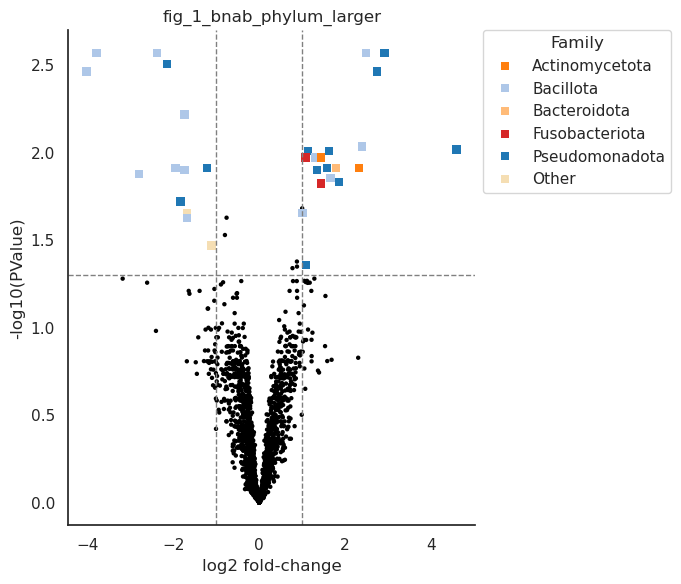

In [25]:


families_to_highlight = ["Bacillota",
"Pseudomonadota",
"Actinomycetota",
"Fusobacteriota",
"Bacteroidota",
"Mycoplasmatota",
"Thermodesulfobacteriota"]
                        
#  want the categories beforehand to build palette safely)
def set_family_plot_from_highlight(res, highlight_families):
    df = res.copy()
    df["family_plot"] = np.where(df["family"].isin(highlight_families), df["family"], "Other")
    df.loc[df["family"].eq("Unknown"), "family_plot"] = "Unknown"
    return df

res_bg_fam2_h = set_family_plot_from_highlight(res_bg_fam2, families_to_highlight)
res_bnabs_fam2_h = set_family_plot_from_highlight(res_bnabs_fam2, families_to_highlight)

# ensure palette covers EVERYTHING that might show up
families_present = set(res_bg_fam2["family"].unique()) | set(res_bnabs_fam2["family"].unique())
shared_palette = rm.ensure_palette_has_families(shared_palette, families_present)


rm.volcano_plot_family_fixed2(
    res_bnabs_fam2,
    palette=shared_palette,
    title="fig_1_bnab_phylum_larger",
    mode="fdr_lfc",
    fdr_thr=5e-2,
    lfc_thr=1.0,
    show_cutoffs=True,
    figsize=(7, 6),
    highlight_families=families_to_highlight
)

# Panel B

## Infectome - GB virus C


In [23]:
pegivirus_r = pd.read_csv('../tables/pegivirus_counts.csv', index_col = 0)

In [24]:
y = pegivirus_r.sum()
y = 1e3*y/(pre_rsa["cleaned_counts"].loc[X.index] - pre_rsa["human_counts"].loc[X.index]) # Normalize it like cfHIV

In [25]:
a = list(design.query("bNAbs == 'Y'").index)
b = list(design.query("bNAbs == 'N'").index)

c = a + b
c = [i for i in c if i != "SAMPLE_100200_1"]

In [26]:

GBVC_heatmap = pd.DataFrame(
    index=meta1.loc[a, "PID"].unique(),
    columns=["1","2","3"],
    dtype=float
)

for s in meta1.loc[a].index.intersection(c).intersection(y.index):
    pid = meta1.loc[s, "PID"]
    arm = s.split("_")[2]           
    GBVC_heatmap.loc[pid, arm] = float(y.loc[s])


In [27]:
# bNAb unproductive — build table
uGBVC_heatmap = pd.DataFrame(
    index=meta1.loc[b, "PID"].unique(),
    columns=["1", "2", "3"],
    dtype=float
)

for pid, sub in meta1.loc[b].groupby("PID"):
    for s in sub.index:
        if s in c:
            uGBVC_heatmap.loc[pid, s.split("_")[2]] = float(y.loc[s])


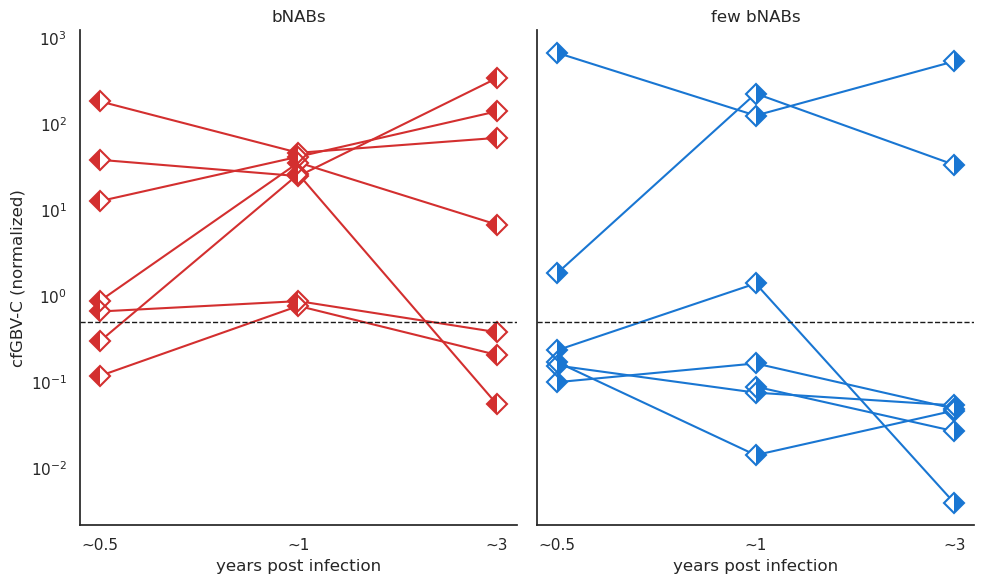

In [28]:
# Paired line plots (productive vs unproductive)
f, axarr = plt.subplots(ncols=2, figsize=(10, 6), sharey=True)

GBVC_heatmap.T.plot(legend=False, color=red, marker='D', markersize=10,
                    markerfacecoloralt="white", fillstyle="left", markeredgewidth=0, ax=axarr[0])
GBVC_heatmap.T.plot(legend=False, color=red, marker='D', linewidth=0, markersize=10,
                    markerfacecoloralt="white", fillstyle="none", markeredgewidth=1.5, ax=axarr[0])

uGBVC_heatmap.T.plot(legend=False, color=blue, marker='D', markersize=10,
                     markerfacecoloralt="white", fillstyle="right", markeredgewidth=0, ax=axarr[1])
uGBVC_heatmap.T.plot(legend=False, color=blue, marker='D', linewidth=0, markersize=10,
                     markerfacecoloralt="white", fillstyle="none", markeredgewidth=1.5, ax=axarr[1])

axarr[0].set_title("bNABs")
axarr[0].set_ylabel("cfGBV-C (normalized)")
axarr[0].axhline(0.5, color='k', ls="dashed", lw=1)
axarr[0].set_xticks([0, 1, 2])
axarr[0].set_xticklabels(["~0.5", "~1", "~3"])
axarr[0].set_xlabel("years post infection")

axarr[1].set_title("few bNABs")
axarr[1].axhline(0.5, color='k', ls="dashed", lw=1)
axarr[1].set_xticks([0, 1, 2])
axarr[1].set_xticklabels(["~0.5", "~1", "~3"])
axarr[1].set_xlabel("years post infection")

plt.yscale("log")
sns.despine()
plt.tight_layout()
os.makedirs('../figures/figure5/panel_A/', exist_ok = True)
plt.savefig("../figures/figure5/panel_A/GBVC.svg")
plt.show()
